# Molecular Similarity

## Objectives

- Generete molecular fingerprints for a given molecule.
- Evaluate structural similarity between molecules using different molecular fingerpints and similarity metrics.

Many useful documents/papers describe various aspects of molecular similarity, including molecular fingerprints and similarity measures.  Please read these if you need more details.

- Getting Started with the RDKit in Python<br>
(https://www.rdkit.org/docs/GettingStartedInPython.html#fingerprinting-and-molecular-similarity)

- Fingerprint Generation, GraphSim Toolkit 2.4.2<br>
(https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html)

- Chemical Fingerprints<br>
(https://docs.chemaxon.com/display/docs/Chemical+Fingerprints)

- Extended-Connectivity Fingerprints<br>
(https://doi.org/10.1021/ci100050t)



## 1. Fingerprint Generation

In [1]:
from rdkit import Chem

In [2]:
mol = Chem.MolFromSmiles('CC(C)C1=C(C(=C(N1CC[C@H](C[C@H](CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4')

### 1-(1) MACCS keys

The MACCS key is a binary fingerprint (a string of 0's and 1's).  Each bit position represents the presence (=1) or absence (=0) of a pre-defined structural feature.  The feature definitions for the MACCS keys are available at:<br> https://github.com/rdkit/rdkit/blob/master/rdkit/Chem/MACCSkeys.py

In [8]:
from rdkit.Chem import MACCSkeys
fp = MACCSkeys.GenMACCSKeys(mol)

In [9]:
print(type(fp))

for i in range(len(fp)):
    print(fp[i], end='')

fp.ToBitString()    # Alternative, easier way to convert it to a bitstring. 

<class 'rdkit.DataStructs.cDataStructs.ExplicitBitVect'>
00000000000000000000000000000000000000000010000000000100000000100100000000110000100101010111100011001000100110110000011001110100110111111101101011111111111111111111110

'00000000000000000000000000000000000000000010000000000100000000100100000000110000100101010111100011001000100110110000011001110100110111111101101011111111111111111111110'

In [10]:
len(fp) #an empty/trivial bit used for indexing, so the length is always Len - 1, one less than the value shown

167

Note that the MACCS key is **166-bit-long**, but RDKit generates a 167-bit-long fingerprint.  It is because the index of a list/vector in many programming languages (including python) begins at 0.  To use the original numbering of the MACCS keys (1-166) (rather than 0-165), the MACCS keys were implemented to be 167-bit-long, with Bit 0 being always zero. Because Bit 0 is set to OFF for all compounds, it does not affect the evaluation of molecular similarity.

These are some methods that allow you to get some additional information on the MACCS Keys.

In [11]:
print(fp.GetNumBits())
print(fp.GetNumOffBits())
print(fp.GetNumOnBits())
print(fp.ToBinary())

167
105
62
b'\xe0\xff\xff\xff\xa7\x00\x00\x00>\x00\x00\x00T\x14\x10\x04\x10\x00\x08\x04\x02\x02\x02\x00\x00\x00\x06\x00\x04\x06\x04\x00\x02\x00\n\x00\x04\x00\x00\x02\x04\x00\x02\x00\x00\x00\x00\x00\x00\x02\x00\x02\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02'


**Exercise 1a:** Generate the MACCS keys for the molecules represented by the following SMILES, and get the positions of the bits set to ON in each of the three fingerprints.  What fragments do these bit positions correspond to?  (the bit definitions are available at

In [12]:
smiles = [ 'C1=CC=CC=C1', # Benzene (Kekule)
           'c1ccccc1',    # Benzene ("Aromatized" carbons)
           'C1CCCCC1']     # Cyclohexene

In [31]:
# Write your code in this cell.
for item in smiles:
    print(item)
    mol = Chem.MolFromSmiles(item)
    
    fp = MACCSkeys.GenMACCSKeys(mol)
    count = 0 
    for i in range(len(fp)):
        print(fp[i], end = '')

    for i in range(len(fp)):
        if fp[i] ==1:
            print ('\n ON', count)

        count += 1
    
print(fp.GetNumBits())
print(fp.GetNumOffBits())
print(fp.GetNumOnBits())
print(fp.ToBinary())
    

C1=CC=CC=C1
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011010
 ON 162

 ON 163

 ON 165
c1ccccc1
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000011010
 ON 162

 ON 163

 ON 165
C1CCCCC1
00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000110000000000000000010000000000000001010
 ON 118

 ON 128

 ON 129

 ON 147

 ON 163

 ON 165
167
161
6
b'\xe0\xff\xff\xff\xa7\x00\x00\x00\x06\x00\x00\x00\xec\x12\x00"\x1e\x02\x02'


<br>**Write the fragment definition of the bits ON** (one is already provided for you as an example).

- 118: ACH2CH2A > 1
- 128: ACH2AAACH2A
- 129: ACH2AACH2A
- 147: ACH2CH2A
- 162: Aromatic
- 163: 6M Ring
- 165: Ring

### 1-(2) Circular Fingerprints

Circular fingerprints are hashed fingerprints.  They are generated by exhaustively enumerating "circular" fragments (containing all atoms within a given radius from each heavy atom of the molecule) and then hashing these fragments into a fixed-length bitstring.  (Here, the "radius" from an atom is measured by the number of bonds that separates two atoms).

Examples of circular fingerprints are the extended-connectivity fingerprint (ECFPs) and their variant called FCFPs (Functional-Class Fingerprints), originally described in a paper by Rogers and Hahn (https://doi.org/10.1021/ci100050t).  The RDKit implementation of these fingerprints are called "Morgan Fingerprints" (https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints).

In [46]:
from rdkit.Chem import AllChem
fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024).ToBitString()
print(fp)

0100000000000100000000000000000001000000000000000000000000000000100000000010000010000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000010000000000000100000000000000000000000010000000000000010000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000001010000000100000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000001000000000000000000000000000000010000000000000000000000000010000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000

When comparing the RDK's Morgan fingerprints with the ECFP/FCFP fingerprints, it is important to remember that the name of ECFP/FCFP fingerprints are suffixed with the **diameter** of the atom environments considered, while the Morgan Fingerprints take a **radius** parameter (e.g., the second argument "2" of GetMorganFingerprintAsBitVect() in the above code cell).  The Morgan fingerprint generated above (with a radius of 2) is comparable to the ECFP4 fingerprint (with a diameter of 4).

**Exercise 1b:** For the moleculess below, generate the 512-bit-long Morgan Fingeprint comparable to the **FCFP6** fingerprint.

- Search for the compounds by name and get their SMILES strings.
- Generate the molecular fingerprints from the SMILES strings.
- Print the generated fingerprints.
- To generate FCFP (not ECFP), read the following document: https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints

In [33]:
synonyms = [ 'diphenhydramine', 'cetirizine', 'fexofenadine', 'loratadine' ]

In [61]:
# Write your code in this cell
import requests
from rdkit import DataStructs
def MorganFingerprints ():
    prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"
    proinput = '/compound/name/'
    prooutput = '/property/isomericsmiles/txt'
    SMILES = []

    for name in synonyms:
        url = prolog + proinput + name + prooutput 
        res = requests.get(url)
        SMILES.append(res.text)
        #print(res.text.split())
        print(name, ':', smiles)
        mol = Chem.MolFromSmiles(SMILES[0])
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 6, nBits=512, useFeatures = True).ToBitString()
        print(fp)
        
MorganFingerprints()
def DiceSimilarity():
    
    DataStructs.DiceSimilarity()
'''
print (SMILES)
for item in SMILES:
    mol = Chem.MolFromSmiles(item)
    fp = AllChem.GetMorganFingerprintAsBitVect(smiles, 2, nBits=1024).ToBitString()
    print(fp)'''


diphenhydramine : ['CCOC(=O)N1CCC(=C2C3=C(CCC4=C2N=CC=C4)C=C(C=C3)Cl)CC1']
10101000000000100010100000000000001000000001000001010000010100000000000000000000110000100000000000000000000000001000000000000000010000000000000000000000000000000010000000010000000000000000000000000000000000000001000000000000000000100000000000000000000000010000000000000000000000000000000000000010010000000100001000100000000001000000000000000000100000100000000000000000000000000000000000000000000000000000000000000000100000000000100000000000000000000000000000000000000000000000000001000000000000000000000000000000
cetirizine : ['CCOC(=O)N1CCC(=C2C3=C(CCC4=C2N=CC=C4)C=C(C=C3)Cl)CC1']
101010000000001000101000000000000010000000010000010100000101000000000000000000001100001000000000000000000000000010000000000000000100000000000000000000000000000000100000000100000000000000000000000000000000000000010000000000000000001000000000000000000000000100000000000000000000000000000000000000100100000001000010001000000000010000000000000000

'\nprint (SMILES)\nfor item in SMILES:\n    mol = Chem.MolFromSmiles(item)\n    fp = AllChem.GetMorganFingerprintAsBitVect(smiles, 2, nBits=1024).ToBitString()\n    print(fp)'

### 1-(3) Path-Based Fingeprints

Path-based fingerprints are also hashed fingerprints.  They are generated by enumerating linear fragments of a given length and hashing them into a fixed-length bitstring.  An example is the RDKit's topological fingeprint.  As described in the RDK documentation (https://www.rdkit.org/docs/GettingStartedInPython.html#topological-fingerprints), while this fingerprint can be generated using FingerprintMols.FingerprintMol(), it is recommended to use rdmolops.RDKFingerprint() to generate the fingerprint using non-default parameter values. 

In [62]:
from rdkit.Chem import rdmolops
fp = rdmolops.RDKFingerprint(mol, fpSize=2048, minPath=1, maxPath=7).ToBitString()
print(fp)

0000000010000000000000010000000000010010000000001001000000000000000010000000000000000000000101000000000100010100100000000100000000000000000000000000000100100100010000100011000000000000000000000010000000100010000010010000000000000000000000000000000010000001000100000000000000000100000000000000001000000001010010000100000100000000001100000001000000000000000000000000001100000000000000000000000000000000000000010000100000000001001100000100001001000000110000000000000000000000000000000000010000000000100000000000000000000000000001000001000100000000100010000000000000100000000100000000000010001000001000000000000000000000000000100000000000000001000000000000000100000000000000000001000000010000000010000000000010000000000000000000000101000000000100101000110000000010000001000000000000001001000000101000001000000000000000000010000000000010000000100010001000010011000100000000010000000000100010000000011000000000000000110000000000000110001000000001001000100000000000000000000010010010010110100000000010000000

### 1-(4) PubChem Fingerprint

The PubChem Fingerprint is a 881-bit-long binary fingerprint (ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf).  Similar to the MACCS keys, it uses a pre-defined fragment dictionary.  The PubChem fingerprint for each compound in PubChem can be downloaded from PubChem.  However, because they are base64-encoded, they should be decoded into binary bitstrings or bitvectors.

Details about how to decode base64-encoded PubChem fingerprints is described on the last page of the PubChem Fingerprint specification (ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.pdf).  Below is a user-defined function that decodes a PubChem fingerprint into a bit string.

In [75]:
from base64 import b64decode

def PCFP_BitString(pcfp_base64) :

    pcfp_bitstring = "".join( ["{:08b}".format(x) for x in b64decode( pcfp_base64 )] )[32:913]
    return pcfp_bitstring
    

In [64]:
pcfps = 'AAADcYBgAAAAAAAAAAAAAAAAAAAAAAAAAAAwAAAAAAAAAAABAAAAGAAAAAAACACAEAAwAIAAAACAACBCAAACAAAgAAAIiAAAAIgIICKAERCAIAAggAAIiAcAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA=='

In [65]:
print( len(PCFP_BitString(pcfps)) )
print(PCFP_BitString(pcfps))

881
10000000011000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001100000000000000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000001100000000000000000000000000000000000000000000000100000000000100000000001000000000000001100000000000010000000000000000000000000000000100000000000000000100000010000100000000000000000000000100000000000000000001000000000000000000000000010001000100000000000000000000000000010001000000010000010000000100010100000000001000100010000100000000010000000000000001000001000000000000000000010001000100000000111000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


The generated bitstring can be converted to a bitvector that can be used for molecular similarity computation in RDKit (to be discussed in the next section).

In [66]:
from rdkit import DataStructs
bitvect = DataStructs.CreateFromBitString(PCFP_BitString(pcfps))
type(bitvect)

rdkit.DataStructs.cDataStructs.ExplicitBitVect

## 2. Computation of similarity scores

In [76]:
import requests
import time

In [77]:
cids = [    54454,  # Simvastatin (Zocor)
            54687,  # Pravastatin (Pravachol)
            60823,  # Atorvastatin (Lipitor)
           446155,  # Fluvastatin (Lescol)   
           446157,  # Rosuvastatin (Crestor)
          5282452,  # Pitavastatin (Livalo)
         97938126 ] # Lovastatin (Altoprev)

Let's get the SMILES strings from PubChem, generate Mol objects from them, and draw their chemical structures.

In [69]:
prolog = "https://pubchem.ncbi.nlm.nih.gov/rest/pug"

str_cid = ",".join([ str(x) for x in cids])

url = prolog + "/compound/cid/" + str_cid + "/property/isomericsmiles/txt"
res = requests.get(url)
smiles = res.text.split()

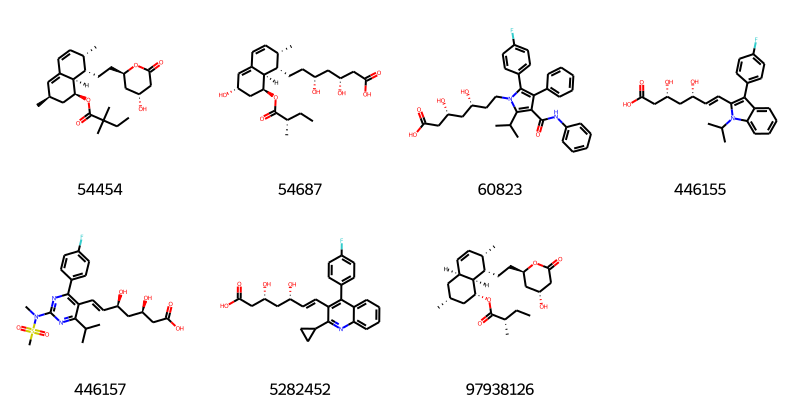

In [70]:
from rdkit import Chem
from rdkit.Chem import Draw

mols = [ Chem.MolFromSmiles(x) for x in smiles ]
Chem.Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200,200), legends=[str(x) for x in cids] )

Now generate MACCS keys for each compound.

In [78]:
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys

fps = [ MACCSkeys.GenMACCSKeys(x) for x in mols ]
print(fps)

[<rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f1488e0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f178c40>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f17d880>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f17d1c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f17d4c0>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f17d100>, <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x7fe50f17d7c0>]


Now let's compute the pair-wise similarity scores among them.  To make higher scores easier to find, they are indicated with the "\*" character(s).

In [80]:
for i in range(0, len(fps)) :
    for j in range(i+1, len(fps)) :
        
        score = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        print(cids[i], "vs.", cids[j], ":", round(score,3), end='')
        
        if ( score >= 0.85 ):
            print(" ****")
        elif ( score >= 0.75 ):
            print(" ***")
        elif ( score >= 0.65 ):
            print(" **")
        elif ( score >= 0.55 ):
            print(" *")
        else:
            print(" ")


54454 vs. 54687 : 0.812 ***
54454 vs. 60823 : 0.354 
54454 vs. 446155 : 0.379 
54454 vs. 446157 : 0.307 
54454 vs. 5282452 : 0.4 
54454 vs. 97938126 : 0.867 ****
54687 vs. 60823 : 0.387 
54687 vs. 446155 : 0.397 
54687 vs. 446157 : 0.287 
54687 vs. 5282452 : 0.421 
54687 vs. 97938126 : 0.8 ***
60823 vs. 446155 : 0.662 **
60823 vs. 446157 : 0.535 
60823 vs. 5282452 : 0.507 
60823 vs. 97938126 : 0.365 
446155 vs. 446157 : 0.526 
446155 vs. 5282452 : 0.735 **
446155 vs. 97938126 : 0.393 
446157 vs. 5282452 : 0.473 
446157 vs. 97938126 : 0.298 
5282452 vs. 97938126 : 0.444 


By default, the similarity score is generated using the **Tanimoto** equation.  RDKit also supports other similarity metrics, including Dice, Cosine, Sokal, Russel, Kulczynski, McConnaughey, and Tversky.  The definition of these metrics is available at the LibreTexts page (https://bit.ly/2kx9NCd).

In [73]:
print("Tanimoto    :", round(DataStructs.TanimotoSimilarity(fps[0], fps[1]), 4))
print("Dice        :", round(DataStructs.DiceSimilarity(fps[0], fps[1]), 4))
print("Cosine      :", round(DataStructs.CosineSimilarity(fps[0], fps[1]), 4))
print("Sokal       :", round(DataStructs.SokalSimilarity(fps[0], fps[1]), 4))
print("McConnaughey:", round(DataStructs.McConnaugheySimilarity(fps[0], fps[1]), 4))

Tanimoto    : 0.8125
Dice        : 0.8966
Cosine      : 0.8971
Sokal       : 0.6842
McConnaughey: 0.7952


The Tversky score is an asymmetric similarity measure, and its computation requires the weightings of the two molecules being compared.

In [74]:
for i in range(0,11) :
    
    alpha = round( i * 0.1, 1 )
    beta = round( 1 - alpha, 1 )
    print("(alpha, beta) = (", alpha, ",", beta, ") : ", end='')
    print(round(DataStructs.TverskySimilarity( fps[0], fps[1], alpha, beta ), 4))

(alpha, beta) = ( 0.0 , 1.0 ) : 0.9286
(alpha, beta) = ( 0.1 , 0.9 ) : 0.922
(alpha, beta) = ( 0.2 , 0.8 ) : 0.9155
(alpha, beta) = ( 0.3 , 0.7 ) : 0.9091
(alpha, beta) = ( 0.4 , 0.6 ) : 0.9028
(alpha, beta) = ( 0.5 , 0.5 ) : 0.8966
(alpha, beta) = ( 0.6 , 0.4 ) : 0.8904
(alpha, beta) = ( 0.7 , 0.3 ) : 0.8844
(alpha, beta) = ( 0.8 , 0.2 ) : 0.8784
(alpha, beta) = ( 0.9 , 0.1 ) : 0.8725
(alpha, beta) = ( 1.0 , 0.0 ) : 0.8667


**Exercise 2a:**  Compute the Tanimoto similarity scores between the seven compounds used in this section, using the PubChem fingerprints

- Download the PubChem Fingerprint for the seven CIDs.
- Convert the downloaded fingerprints into bit vectors.
- Compute the pair-wise Tanimoto scores using the bit vectors.

In [63]:
# Write your code in this cell





## 3. Interpretation of similarity scores

Using molecular fingeprints. we can compute the similarity scores between molecules.  However, how should these scores be interpreted?  For example, the Tanimoto score between CID 60823 and CID 446155 is computed to be 0.662, but does it mean that the two compounds are similar?  How similar is similar?  The following analysis would help answer these questions.

**Step 1.** Randomly select 1,000 compounds from PubChem and download their SMILES strings.

In [31]:
import time
import random
random.seed(0)

cid_max = 138962044    # The maximum CID in PubChem as of September 2019

cids = []

for x in range(1000):
    cids.append(random.randint(1, cid_max + 1))

chunk_size = 100

if len(cids) % chunk_size == 0 :
    num_chunks = int( len(cids) / chunk_size )
else :
    num_chunks = int( len(cids) / chunk_size ) + 1

smiles = []
    
for i in range(num_chunks):

    if (i == 0):
        print("Processing chunk ", end='')
    
    print(i, end=' ')
    
    idx1 = chunk_size * i
    idx2 = chunk_size * (i + 1)
    str_cids = ",".join([ str(x) for x in cids[idx1:idx2]])

    url = prolog + "/compound/cid/" + str_cids + "/property/isomericsmiles/txt"
    res = requests.get(url)

    if ( res.status_code == 200) :
        smiles.extend( res.text.split() )
    else :
        print("Chunk", i, "Failed to get SMILES.")
        
    time.sleep(0.2)

print("Done!")
print("# Number of SMILES : ", len(smiles))

print(smiles[0])

Processing chunk 0 1 2 3 4 5 6 7 8 9 Done!
# Number of SMILES :  1000
CC1=C(C(=NN1CCCOCCOC)C)CCNC2CC2


**Step 2.** Generate the MACCSKeys for each compound.

In [29]:
from rdkit import Chem

mols = [ Chem.MolFromSmiles(x) for x in smiles if x != None ]
fps  = [ MACCSkeys.GenMACCSKeys(x) for x in mols if x != None ]
print("# Number of compounds:", len(mols))
print("# Number of fingerprints:", len(fps))

[09:57:35] WARNING: not removing hydrogen atom without neighbors


# Number of compounds: 1000
# Number of fingerprints: 1000


In [66]:
# Run this cell if the number of compounds != the number of fingerprints.
#if ( len(cids) != len(fps) ):
#    print("SMILES at index", mols.index(None), ":", smiles[ mols.index(None) ])

**Step 3.** Compute the Tanimoto scores between compounds.

In [30]:
print("# The number of compound pairs:", (len(fps) * (len(fps) - 1))/2 )

# The number of compound pairs: 499500.0


In [68]:
scores = []

for i in range(0, len(fps)) :

    if (i == 0) :
        print("Processing compound ", end='')
    
    if (i % 100 == 0) :
        print(i, end=' ')
    
    for j in range(i+1, len(fps)) :
        scores.append(DataStructs.FingerprintSimilarity(fps[i], fps[j]))

print("Done!")
print("# Number of scores : ", len(scores))

Processing compound 0 100 200 300 400 500 600 700 800 900 Done!
# Number of scores :  499500


**Step 4.** Generate a histogram that shows the distribution of the pair-wise scores.

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

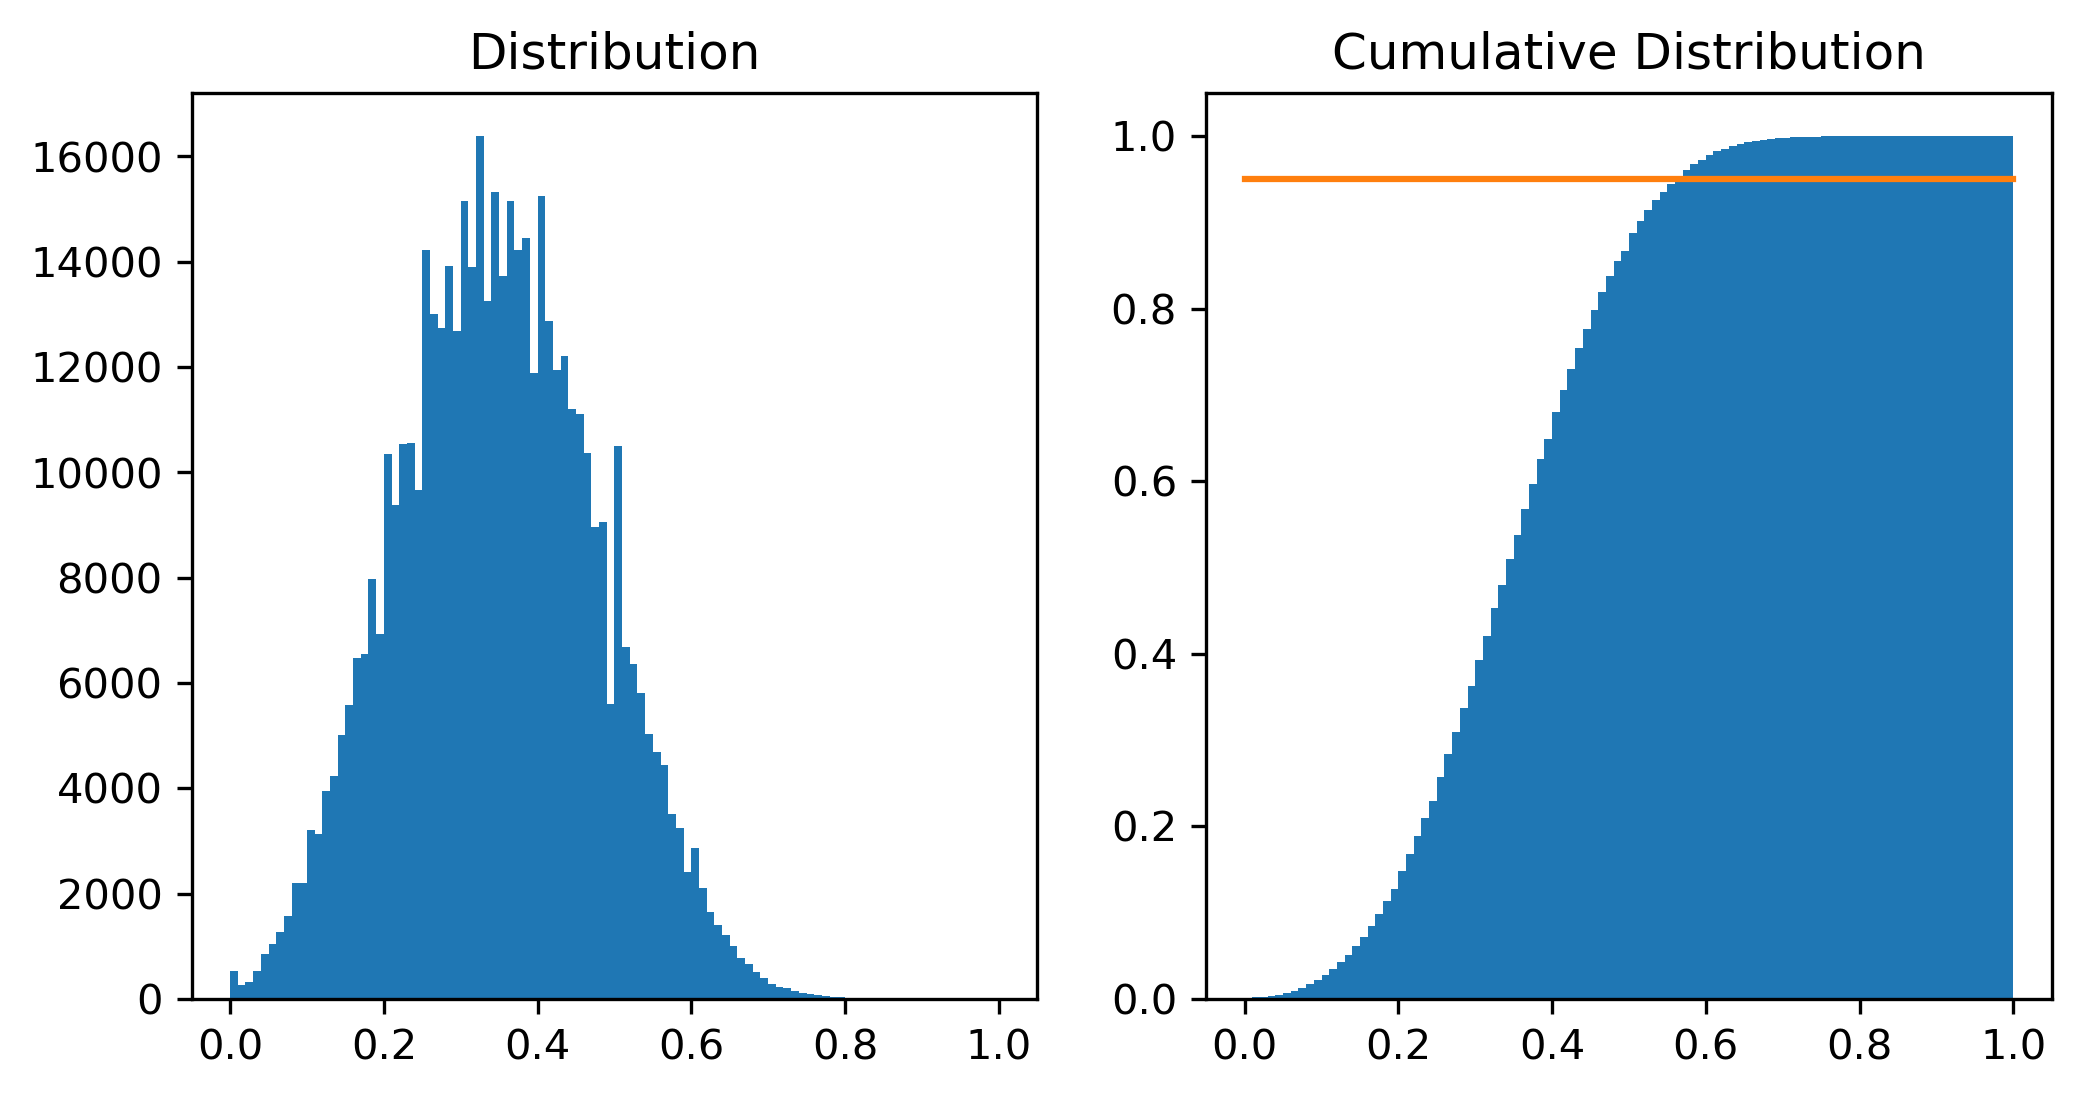

In [70]:
mybins = [ x * 0.01 for x in range(101)]

fig = plt.figure(figsize=(8,4), dpi=300)

plt.subplot(1, 2, 1)
plt.title("Distribution")
plt.hist(scores, bins=mybins)

plt.subplot(1, 2, 2)
plt.title("Cumulative Distribution")
plt.hist(scores, bins=mybins, density=True, cumulative=1)
plt.plot([0,1],[0.95,0.95]);

In [71]:
for i in range(21) :

    thresh = i / 20
    num_similar_pairs = len([x for x in scores if x >= thresh]) 
    prob = num_similar_pairs / len(scores) * 100
    print("%.3f %8d (%8.4f %%)" % (thresh, num_similar_pairs, round(prob,4)))

0.000   499500 (100.0000 %)
0.050   497010 ( 99.5015 %)
0.100   488714 ( 97.8406 %)
0.150   469193 ( 93.9325 %)
0.200   435672 ( 87.2216 %)
0.250   385198 ( 77.1167 %)
0.300   318637 ( 63.7912 %)
0.350   245621 ( 49.1734 %)
0.400   175158 ( 35.0667 %)
0.450   111668 ( 22.3560 %)
0.500    66599 ( 13.3331 %)
0.550    32209 (  6.4482 %)
0.600    13897 (  2.7822 %)
0.650     4668 (  0.9345 %)
0.700     1351 (  0.2705 %)
0.750      355 (  0.0711 %)
0.800       76 (  0.0152 %)
0.850       24 (  0.0048 %)
0.900        6 (  0.0012 %)
0.950        1 (  0.0002 %)
1.000        0 (  0.0000 %)


In [72]:
print("Average:", sum(scores)/len(scores))

Average: 0.3488195436976387


From the distribution of the similarity scores among 1,000 compounds, we observe the following:<br>
- If you randomly select two compounds from PubChem, the similarity score between them (computed using the Tanimoto equation and MACCS keys) is ~0.35 on average.
- About %5 of randomly selected compound pairs have a similarity score greater than 0.55.
- About %1 of randomly selected compound pairs have a similarity score greater than 0.65.

If two compounds have a Tanimoto score of 0.35, it is close to the avaerage Tanimoto score between randomly selected compounds and there is a 50% chance that you will get a score of 0.35 or greater just by selecting two compounds from PubChem.  Therefore, it is reasonable to consider the two compounds are not similar.<br>

The Tanimoto index may have a value ranging from 0 (for no similarity) to 1 (for identical molecules) and the midpoint of this value range is 0.5.  Because of this, a Tanimoto score of **0.55** may not sound great enough to consider two compounds to be similar.  However, according to the score distribution curve generated here, only **~5%** of randomly selected compound pairs will have a score greater than this.<br>

In the previous section, we computed the similarity scores between some cholesterol-lowering drugs, and CID 60823 and CID 446155 had a Tanimoto score of **0.662**.  Based on the score distribution curve generated in the second section, we can say that the probablilty of two randomly selected compounds from PubChem having a Tanimoto score greater than 0.662 is **less than 1%**.

The following code cell demonstrates how to find an appropriate similarity score threshold above which a given percentage of the compound pairs will be considered to be similar to each other.

In [73]:
scores.sort()    # Sort the scores in an increasing order.

In [74]:
# to find a threshold for top 3% compound pairs (i.e., 97% percentile)
print("# total compound pairs:   ", len(scores))
print("# 95% of compound pairs:  ", len(scores) * 0.97)
print("# score at 95% percentile:", scores[ round(len(scores) * 0.97) ] )


# total compound pairs:    499500
# 95% of compound pairs:   484515.0
# score at 95% percentile: 0.5945945945945946


**Exercise 3a:** In this exercise, we want to generate the distribution of the similarity scores among 1,000 compounds randomly selected from PubChem, using different molecular fingeprints and similarity metrics.<br>
For molecular fingerprints, use the following:
- PubChem Fingerprint
- MACCS keys
- Morgan Fingerprint (ECFP4 analogue, 1024-bit-long)

For similarity metrics, use the following:
- Tanimoto similarity
- Dice similarity
- Cosine similarity

As a result, a total of 9 distribution curves need to be generated.  

Here are additional instructions to follow:
- When generating the histograms, bin the scores from 0 to 1 with an increment of 0.01.
- For each distribution curve, determine the similarity score threshold so that **1%** of the compound pairs have a similarity score greater than or equal to this threshold.
- Use RDKit to generate the MACCS keys and Morgan fingerprint and download the PubChem fingerprints from PubChem.
- For reproducibility, use **random.seed(2019)** before you generate random CIDs.

**Step 1:** Generate 1,000 random CIDs, download the isomeric SMILES for them, and create the RDKit mol objects from the downloaded SMILES strings.

In [75]:
# Write your code in this cell





**Step 2:**  Generate the fingerprints, compute the similarity scores, determine similarity thresholds, and make histograms.

In [76]:
# Write your code in this cell



